# Pipeline 

## Importando bibliotecas necessárias: 

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

import sys
sys.path.append("../src")
from custom_transformers import FeatureEngineeringTransformer

import joblib

## Carregando os dados 

In [2]:
# identificando diretório base 
base_dir = Path.cwd()

# caminho para a pasta contendo o dataset  
data_dir = base_dir.parent / "data"

# caminho para o dataset 
df_path = data_dir / "dataset_2021-5-26-10-14.csv"

# importando o arquivo csv para um dataframe pandas
df = pd.read_csv(df_path, sep="\t", encoding="utf-8")

df.head()

,default_3months,ioi_36months,ioi_3months,valor_por_vencer,valor_vencido,valor_quitado,quant_protestos,valor_protestos,quant_acao_judicial,acao_judicial_valor,...,dividas_vencidas_qtd,falencia_concordata_qtd,tipo_sociedade,opcao_tributaria,atividade_principal,forma_pagamento,valor_total_pedido,month,year,default
0,0,58.000000,18.236092,0.00,0.0,242100.70,0,0.0,0,0.0,...,0,0,empresario (individual),simples nacional,papelaria,30/60/90,34665.674938,6,2019,0
1,1,16.052632,7.500000,224132.85,0.0,4960846.21,0,0.0,0,0.0,...,0,0,sociedade empresaria limitada,missing,com de equipamentos de informatica,30/60/90,7134.489373,10,2018,0
2,0,13.250000,3.904762,513043.83,0.0,158631.93,1,1800.0,0,0.0,...,0,0,sociedade empresaria limitada,simples nacional,servicos de vigilancia e guarda,missing,72653.621143,4,2018,0
3,0,136.925000,10.144219,23273.64,0.0,669644.16,0,0.0,0,0.0,...,0,0,empresario (individual),simples nacional,com de equipamentos de informatica,missing,14576.805783,4,2017,1
4,0,140.333333,17.651678,0.00,0.0,2010.56,0,0.0,0,0.0,...,0,0,sociedade empresaria limitada,simples nacional,com de compon eletron e pecas para eletrod,30/60/90,2655.505663,10,2017,0


## Tratamento e Limpeza dos dados

*  Remoção de valores ausentes das variáveis (`tipo_sociedade` e `atividade_principal`).

*  Criação de colunas binárias para os valores ausentes das variáveis `opcao_tributaria` e `forma_pagamento`.

*  Remoção das linhas com valores negativos em `valor_total_pedido`.

*  Remoção de variável (`participacao_falencia_valor`) com apenas um valor.

*  Remoção de linha "sem_pagamento" em `forma_pagamento`. 

*  Conversão de variáveis para valores inteiros.

## Feature Engineering 

*  As variáveis financeiras possuem grande variância, para reduzir a assimetria elas serão transformadas em log. 

*  Agrupamento de categorias de algumas variáveis categóricas. 

Agrupando as categorias em `tipo_sociedade` por mesmo tipo de natureza jurídica e frequência relativa de cada categoria: 

*  Individual: empresario (individual), empresario-mei (microempreendedor individual), empresa individual respons limitada empresaria 

*  Sociedade empresarial: sociedade empresa limitada, sociedade anônima fechada, sociedade anônima aberta, sociedade de economia mista

*  Sociedade simples: sociedade simples pura, sociedade simples limitada

*  Cooperativa: cooperativa

*  Outros**: entidal sindical, munícipio, serviço social autônomo, organização religiosa, fundação privada, outras formas de associação 

**(não se enquadram em outras categorias e são pouco representativas no dataset)
 

Agrupando as categorias em `atividade_principal` por frequência (categorias menores que 2% agrupadas em outros)

Este agrupamento por frequência é uma solução simples para reduzir a fragmentação de categorias. Em um cenário real, poderíamos ter um dicionário de mapeamento mais refinado (por exemplo, separar ‘comércio’, ‘serviços’, ‘indústria’, etc.) para tornar a classificação mais coerente com o negócio.

Transformar os dados da "forma_pagamento" e extrair indicadores:

*  Número de parcelas

*  Prazo médio: a média das parcelas 

*  Prazo máximo: a parcela mais longa

*  Classificar os prazos em: curto, médio, longo, muito longo, missing





## Separação em Treino e Teste  

Para lidar com o desbalanceamento da variável alvo (default), serão testadas duas abordagens:

*  Utilizar "class_weight" - dar mais peso à classe minoritária (default)
*  Fazer oversampling (SMOTE) - aumentar o número de exemplos de default 

### Limpeza dos dados - remoção de variáveis/valores

In [3]:
# removendo linhas do dataframe
df = df.loc[(df['tipo_sociedade'] != 'missing') &  (df['atividade_principal'] != 'missing')].copy()
df = df[df['valor_total_pedido'] >= 0].copy()
df = df[df['forma_pagamento'] != 'sem_pagamento'].copy()
df.drop('participacao_falencia_valor', axis=1, inplace=True)

In [4]:
print(df['default'].value_counts(normalize=True))

default
0    0.832904
1    0.167096
Name: proportion, dtype: float64


### Separação em treino e teste

In [5]:
# definindo x como todas as colunas exceto 'default' e y como 'default' (alvo)

y = df['default']

x = df.drop('default', axis=1)

In [6]:
# dividindo os dados em treino e teste 
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.2, 
    random_state=13, 
    stratify=y
)

print("X_train:", x_train.shape)
print("X_test:", x_test.shape)

X_train: (93206, 20)
X_test: (23302, 20)


In [7]:
feature_engineering = FeatureEngineeringTransformer()

In [8]:
x_transformed = feature_engineering.fit_transform(x_train)

x_transformed.head()

,default_3months,ioi_36months,ioi_3months,opcao_tributaria,year,quant_protestos_bin,quant_acao_judicial_bin,dividas_vencidas_qtd_bin,falencia_concordata_qtd_bin,default_3months_bin,...,n_parcelas,prazo_medio,prazo_maximo,classificacao_prazo,opcao_tributaria_missing,forma_pagamento_missing,atividade_agrupada,prop_vencido,prop_quitado,trimestre
92156,0,56,15,simples nacional,2018,0,0,0,0,0,...,5.0,90.0,150.0,longo,0,0,outros,0.000000,0.999975,3
1697,0,48,72,simples nacional,2018,0,0,0,0,0,...,3.0,35.0,42.0,medio,0,0,comercio,0.000000,0.982773,1
75093,0,6,5,simples nacional,2018,0,0,0,0,0,...,3.0,42.0,56.0,medio,0,0,comercio,0.000000,0.951971,4
15013,0,8,6,simples nacional,2018,0,0,0,0,0,...,5.0,56.0,70.0,medio,0,0,comercio,0.000000,0.991043,3
113101,0,5,8,simples nacional,2019,0,0,0,0,0,...,5.0,56.0,70.0,medio,0,0,comercio,0.003362,0.953409,2


In [9]:
#determinando as colunas numéricas e categóricas
num_features = x_transformed.select_dtypes(include=["int64", "float64"]).columns
cat_features = x_transformed.select_dtypes(include=["object", "category"]).columns

In [10]:
# pipeline para variáveis numéricas 
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=-1)), ('scaler', StandardScaler())])

# pipeline para variáveis categóricas   
cat_pipeline = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [11]:
preprocessor = ColumnTransformer([('num', num_pipeline, num_features),('cat', cat_pipeline, cat_features)])

In [12]:
# modelos a serem testados/comparados
model_dict = { 
    "Logistic_Regression": LogisticRegression(random_state=42, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=42, scale_pos_weight=(len(y_train) - sum(y_train))/sum(y_train)),
}

Função de avaliação de performance de diferentes modelos (Regressão Logística, RandomForest e XGBoost)

In [13]:
# testar os modelos e obter métricas 
def compara_modelos(model, x_train, y_train, x_test, y_test, model_name= "Model"):
    '''

    Função que treina um modelo e retorna métricas, curva roc e matriz de confusão

    '''

    clf = Pipeline([("feature_engineering", feature_engineering), ("preprocessor", preprocessor),("classifier", model)])

    # treinar o modelo
    clf.fit(x_train, y_train)

    # prediz no conjunto de teste
    y_pred = clf.predict(x_test)
    y_prob = clf.predict_proba(x_test)[:,1]

    # prediz no conjunto de treino
    y_train_pred = clf.predict(x_train)
    y_train_prob = clf.predict_proba(x_train)[:, 1]

    # métricas teste 
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

     # métricas treino
    rec_train = recall_score(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_prob)
    acc_train = accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)
    prec_train = precision_score(y_train, y_train_pred)

    # printar as metricas 
    print(f"\n =========== {model_name} =========== ")
    print(f"Classification report teste:")
    print(classification_report(y_test, y_pred, digits=4))


    print(f"TESTE: Acurácia: {acc:.2f}, Precisão {prec:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}, AUC: {auc:.2f}\n")
    print(f"TREINO: Acurácia: {acc_train:.2f}, Precisão {prec_train:.2f}, Recall: {rec_train:.2f}, F1: {f1_train:.2f}, AUC: {auc_train:.2f}\n")

    # matriz de confusão
    print(f"\nMatriz de Confusão teste\n")
    matriz = confusion_matrix(y_test, y_pred)
    print(matriz)

    # análise de overfitting
    print("\nComparação para Overfitting:")
    print(f"Diferença AUC (Treino - Teste): {auc_train - auc:.4f}")
    print(f"Diferença Recall (Treino - Teste): {rec_train - rec:.4f}")

    # curva roc
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, marker='.', label=f"{model_name} (AUC = {auc:.2f})")
        plt.xlabel('Taxa de Falsos Positivos')
        plt.ylabel('Taxa de Verdadeiros Positivos')
        plt.title('Curva Roc')
        plt.legend()
        plt.show()

    return {
        "Modelo": model_name,
        "Acurácia": acc,
        "Precisão": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "Overfitting_Recall": rec_train - rec,
        "Overfitting_AUC": auc_train - auc
    }

/home/maiara/miniconda3/envs/X-health-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 =========== Logistic_Regression =========== 
Classification report teste:
              precision    recall  f1-score   support

           0     0.9273    0.7239    0.8131     19408
           1     0.3426    0.7173    0.4637      3894

    accuracy                         0.7228     23302
   macro avg     0.6350    0.7206    0.6384     23302
weighted avg     0.8296    0.7228    0.7547     23302

TESTE: Acurácia: 0.72, Precisão 0.34, Recall: 0.72, F1: 0.46, AUC: 0.80

TREINO: Acurácia: 0.72, Precisão 0.34, Recall: 0.71, F1: 0.46, AUC: 0.80


Matriz de Confusão teste

[[14049  5359]
 [ 1101  2793]]

Comparação para Overfitting:
Diferença AUC (Treino - Teste): -0.0061
Diferença Recall (Treino - Teste): -0.0036


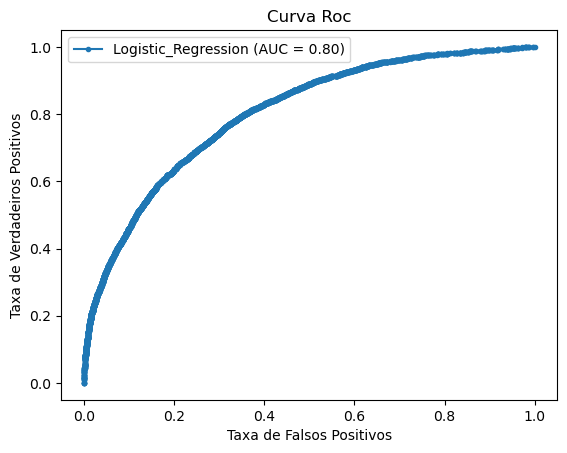


 =========== RandomForest =========== 
Classification report teste:
              precision    recall  f1-score   support

           0     0.9024    0.9855    0.9421     19408
           1     0.8666    0.4689    0.6086      3894

    accuracy                         0.8992     23302
   macro avg     0.8845    0.7272    0.7754     23302
weighted avg     0.8964    0.8992    0.8864     23302

TESTE: Acurácia: 0.90, Precisão 0.87, Recall: 0.47, F1: 0.61, AUC: 0.92

TREINO: Acurácia: 1.00, Precisão 1.00, Recall: 1.00, F1: 1.00, AUC: 1.00


Matriz de Confusão teste

[[19127   281]
 [ 2068  1826]]

Comparação para Overfitting:
Diferença AUC (Treino - Teste): 0.0838
Diferença Recall (Treino - Teste): 0.5309


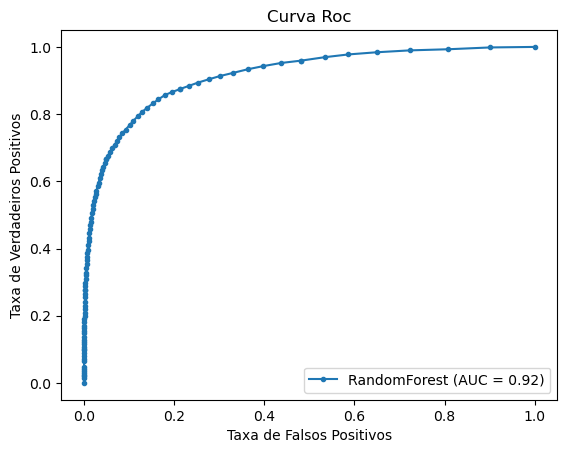


 =========== XGBoost =========== 
Classification report teste:
              precision    recall  f1-score   support

           0     0.9537    0.8486    0.8981     19408
           1     0.5129    0.7948    0.6235      3894

    accuracy                         0.8396     23302
   macro avg     0.7333    0.8217    0.7608     23302
weighted avg     0.8801    0.8396    0.8522     23302

TESTE: Acurácia: 0.84, Precisão 0.51, Recall: 0.79, F1: 0.62, AUC: 0.90

TREINO: Acurácia: 0.86, Precisão 0.56, Recall: 0.87, F1: 0.68, AUC: 0.94


Matriz de Confusão teste

[[16469  2939]
 [  799  3095]]

Comparação para Overfitting:
Diferença AUC (Treino - Teste): 0.0388
Diferença Recall (Treino - Teste): 0.0737


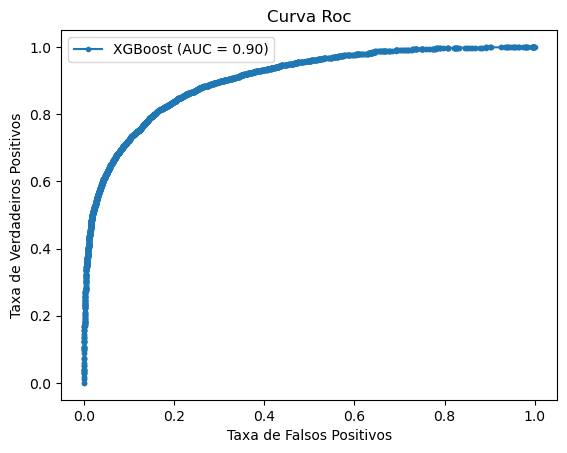

In [14]:
results = []

for name, clf in model_dict.items():
    metrics = compara_modelos(
        clf, 
        x_train, y_train, 
        x_test, y_test, 
        model_name=name
    )
    results.append(metrics)

In [15]:
comparison = pd.DataFrame(results)
display(comparison)

,Modelo,Acurácia,Precisão,Recall,F1,AUC,Overfitting_Recall,Overfitting_AUC
0,Logistic_Regression,0.722771,0.342615,0.717257,0.463722,0.802492,-0.003568,-0.006078
1,RandomForest,0.899193,0.866635,0.468927,0.608565,0.916168,0.530881,0.083832
2,XGBoost,0.839585,0.512927,0.794813,0.623489,0.904967,0.073686,0.038839


In [16]:
# modelo escolhido para otimização --> XGBoost
xgb_model = XGBClassifier(random_state=42,scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train))

In [17]:
# criar pipeline para o modelo XGBoost 
pipeline_xgb = Pipeline([("feature_engineering", feature_engineering), ("preprocessor", preprocessor),("classifier", xgb_model)])

In [18]:
# parâmetros para otimização do modelo XGBoost
param = {'classifier__n_estimators': [50, 100, 200, 300, 500],
    'classifier__max_depth': [3, 5, 6],
    'classifier__learning_rate': np.linspace(0.01, 0.3, 5),
    'classifier__subsample': np.linspace(0.5, 1.0, 5),
    'classifier__colsample_bytree': np.linspace(0.5, 1.0, 5),
    'classifier__gamma': [0, 1, 3, 5],
    'classifier__reg_lambda': np.logspace(-2, 1, 5), 
    'classifier__reg_alpha': np.logspace(-2, 1, 5)}


random_search = RandomizedSearchCV(
    estimator=pipeline_xgb,
    param_distributions=param,
    n_iter=20,  
    scoring='recall',  
    cv=5,  
    verbose=2,
    random_state=42
)

# rodar a busca de hiperparâmetros
random_search.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END classifier__colsample_bytree=0.875, classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__reg_alpha=1.7782794100389228, classifier__reg_lambda=0.05623413251903491, classifier__subsample=0.875; total time=   8.6s
[CV] END classifier__colsample_bytree=0.875, classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__reg_alpha=1.7782794100389228, classifier__reg_lambda=0.05623413251903491, classifier__subsample=0.875; total time=   8.5s
[CV] END classifier__colsample_bytree=0.875, classifier__gamma=1, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__reg_alpha=1.7782794100389228, classifier__reg_lambda=0.05623413251903491, classifier__subsample=0.875; total time=   8.8s
[CV] END classifier__colsample_bytree=0.875, classifier__gamma=1, classifier__le

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7cbae28bf580>>
Traceback (most recent call last):
  File "/home/maiara/miniconda3/envs/X-health-env/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


[CV] END classifier__colsample_bytree=0.875, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__reg_alpha=10.0, classifier__reg_lambda=0.01, classifier__subsample=0.75; total time=   9.1s
[CV] END classifier__colsample_bytree=0.875, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__reg_alpha=10.0, classifier__reg_lambda=0.01, classifier__subsample=0.75; total time=   9.4s
[CV] END classifier__colsample_bytree=0.875, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__reg_alpha=10.0, classifier__reg_lambda=0.01, classifier__subsample=0.75; total time=   8.8s
[CV] END classifier__colsample_bytree=0.875, classifier__gamma=0, classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__reg_alpha=10.0, classifier__reg_lambda=0.01, classifier__subsamp

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('feature_engineering',
                                              FeatureEngineeringTransformer()),
                                             ('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=-1,
                                                                                                              strategy='constant')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['default_3months', 'ioi_36months', 'ioi_3months', 'year',
       'quant_protestos_bin'...
                                        'classifier__learning_rate': array([0.01  , 0.0825, 0.155 , 0.2275, 0.3   ]),
                                        'classifier__max_depth': [3, 5, 6],
                                        'classifier__n_estimators': [50, 100,
                                                                     200, 300,
                                                                     500],
                                        'classifier__reg_alpha': array([ 0.01      ,  0.05623413,  0.31622777,  1.77827941, 10.        ]),
                                        'classifier__reg_lambda': array([ 0.01      ,  0.05623413,  0.31622777,  1.77827941, 10.        ]),
                                        'classifier__subsample': array([0.5  , 0.625, 0.75 , 0.875, 1.   ])},
                   random_state=42, scoring='recall', verbose=2)

In [19]:
# os melhores hiperparâmetros encontrados são:
print("Melhores hiperparâmetros:", random_search.best_params_)
print("Melhor recall obtido:", random_search.best_score_)

Melhores hiperparâmetros: {'classifier__subsample': np.float64(0.875), 'classifier__reg_lambda': np.float64(10.0), 'classifier__reg_alpha': np.float64(10.0), 'classifier__n_estimators': 500, 'classifier__max_depth': 5, 'classifier__learning_rate': np.float64(0.08249999999999999), 'classifier__gamma': 1, 'classifier__colsample_bytree': np.float64(0.75)}
Melhor recall obtido: 0.7864390610003392


In [20]:
# rodar modelo com hiperparâmetros encontrados em random_search 
best_pipeline = random_search.best_estimator_

best_pipeline.fit(x_train, y_train)
y_pred = best_pipeline.predict(x_test)

In [21]:
# métricas do modelo otimizado teste 
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
y_prob = best_pipeline.predict_proba(x_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)

print(f"TESTE: Acurácia: {acc:.2f}, Precisão {prec:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}, AUC: {auc:.2f}\n")

# métricas do modelo otimizado treino
y_pred_train = best_pipeline.predict(x_train)
y_prob_train = best_pipeline.predict_proba(x_train)[:, 1]

acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
rec_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)
auc_train = roc_auc_score(y_train, y_prob_train)

print(f"TREINO: Acurácia: {acc_train:.2f}, Precisão {prec_train:.2f}, Recall: {rec_train:.2f}, F1: {f1_train:.2f}, AUC: {auc_train:.2f}")

TESTE: Acurácia: 0.83, Precisão 0.50, Recall: 0.80, F1: 0.61, AUC: 0.90

TREINO: Acurácia: 0.85, Precisão 0.52, Recall: 0.85, F1: 0.65, AUC: 0.93


In [22]:
# salvando modelo na pasta model do repositório
joblib.dump(best_pipeline, "../model/pipeline_predicao_default.pkl")

['../model/pipeline_predicao_default.pkl']

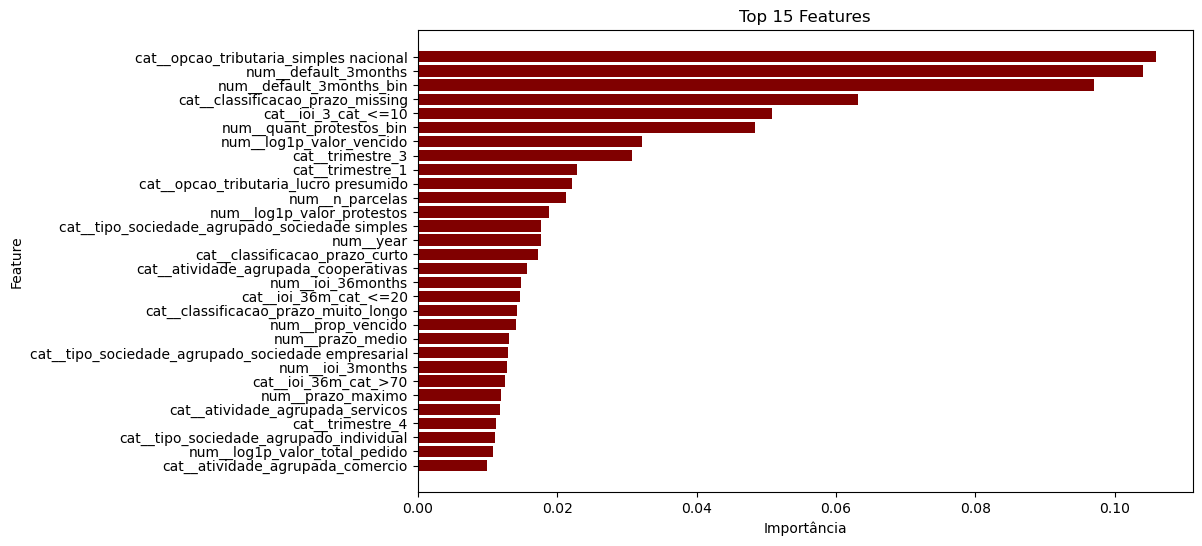

                                              Feature  Importance
28             cat__opcao_tributaria_simples nacional    0.105880
0                                num__default_3months    0.104078
8                            num__default_3months_bin    0.096958
45                   cat__classificacao_prazo_missing    0.063200
35                                cat__ioi_3_cat_<=10    0.050757
4                            num__quant_protestos_bin    0.048415
10                           num__log1p_valor_vencido    0.032159
56                                   cat__trimestre_3    0.030768
54                                   cat__trimestre_1    0.022865
25              cat__opcao_tributaria_lucro presumido    0.022081
17                                    num__n_parcelas    0.021279
12                         num__log1p_valor_protestos    0.018836
41     cat__tipo_sociedade_agrupado_sociedade simples    0.017747
3                                           num__year    0.017689
42        

In [23]:
importances = best_pipeline["classifier"].feature_importances_
feature_names = best_pipeline["preprocessor"].get_feature_names_out()

# cria df de importancia das features
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# plot de top 15 features mais importantes
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"][:30], feature_importance_df["Importance"][:30], color='maroon')
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.title("Top 15 Features")
plt.gca().invert_yaxis()  # Inverter eixo para a mais importante ficar no topo
plt.show()

print(feature_importance_df.head(61))


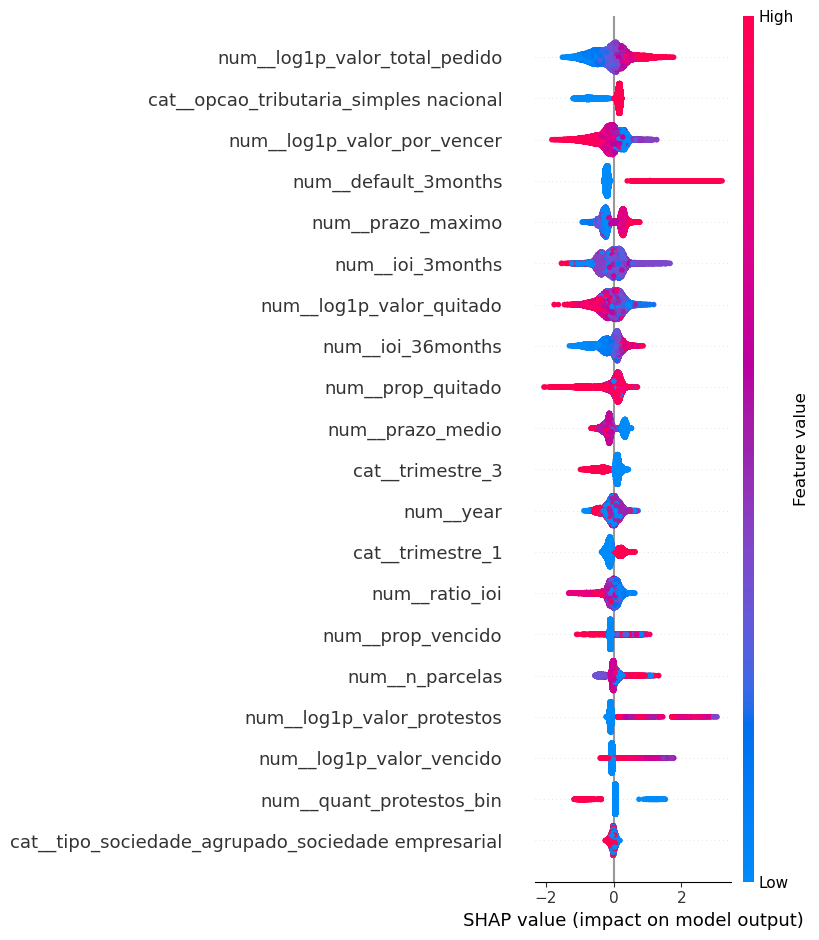

In [24]:
import shap

# Criar objeto SHAP
explainer = shap.Explainer(best_pipeline["classifier"])
X_test_processed = best_pipeline[:-1].transform(x_test)

explainer = shap.TreeExplainer(best_pipeline["classifier"])

shap_values = explainer(X_test_processed)

feature_names = best_pipeline["preprocessor"].get_feature_names_out()
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names)